#DA5401 Assignment #6
## **Imputation via Regression for Missing Data**


**Name:** Ranjith.V.R<br> **Roll no:** EE24S034 <br> ***Indian Institute of Technology , Madras***



In [1]:
# ================================================================
# DA5401 A6 : Imputation via Regression for Missing Data
# ================================================================
# Objective: Compare simple, linear, and non-linear regression imputations
# on the UCI Credit Card Default dataset.
# ================================================================

# --- Imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.neighbors import KNeighborsRegressor
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report
import missingno as msno

sns.set(style="whitegrid")
import warnings
warnings.filterwarnings("ignore")

##Part A – Data Preprocessing and Imputation

1.Loading and Preparing the Data

- In this step, I began by loading the UCI Credit Card Default Clients Dataset from Kaggle. Before performing any imputation, I carefully inspected the data structure, feature names, and missing value patterns.
Although the original dataset is relatively clean, the assignment required simulating a realistic missing data scenario.

In [2]:
# --- Load dataset (CLEAN base dataset used fresh each time)
df_clean = pd.read_csv("/content/UCI_Credit_Card.csv")

# Fix target column name
if 'default.payment.next.month' in df_clean.columns:
    df_clean.rename(columns={'default.payment.next.month': 'default payment next month'}, inplace=True)

# Drop any unnamed index column if present
df_clean = df_clean.loc[:, ~df_clean.columns.str.contains('^Unnamed')]

print("Shape:", df_clean.shape)
df_clean.head()


Shape: (30000, 25)


,ID,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_0,PAY_2,PAY_3,PAY_4,...,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,default payment next month
0,1,20000.0,2,2,1,24,2,2,-1,-1,...,0.0,0.0,0.0,0.0,689.0,0.0,0.0,0.0,0.0,1
1,2,120000.0,2,2,2,26,-1,2,0,0,...,3272.0,3455.0,3261.0,0.0,1000.0,1000.0,1000.0,0.0,2000.0,1
2,3,90000.0,2,2,2,34,0,0,0,0,...,14331.0,14948.0,15549.0,1518.0,1500.0,1000.0,1000.0,1000.0,5000.0,0
3,4,50000.0,2,2,1,37,0,0,0,0,...,28314.0,28959.0,29547.0,2000.0,2019.0,1200.0,1100.0,1069.0,1000.0,0
4,5,50000.0,1,2,1,57,-1,0,-1,0,...,20940.0,19146.0,19131.0,2000.0,36681.0,10000.0,9000.0,689.0,679.0,0


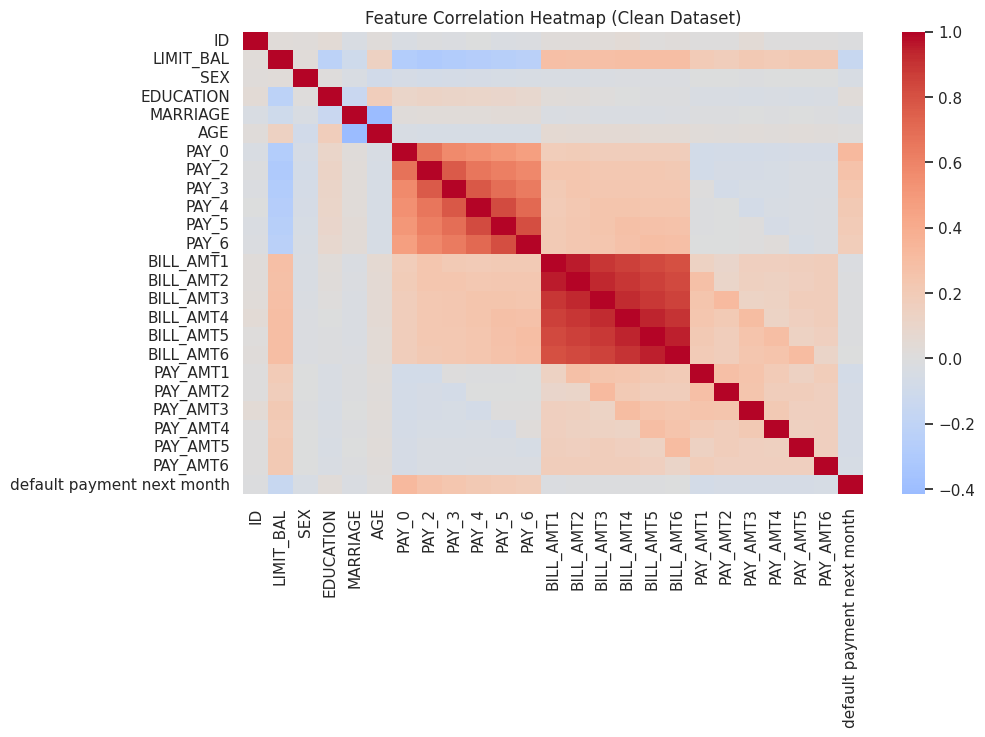

In [3]:
# --- Visualize correlations & distributions in the clean dataset
plt.figure(figsize=(10,6))
sns.heatmap(df_clean.corr(numeric_only=True), cmap="coolwarm", center=0)
plt.title("Feature Correlation Heatmap (Clean Dataset)")
plt.show()



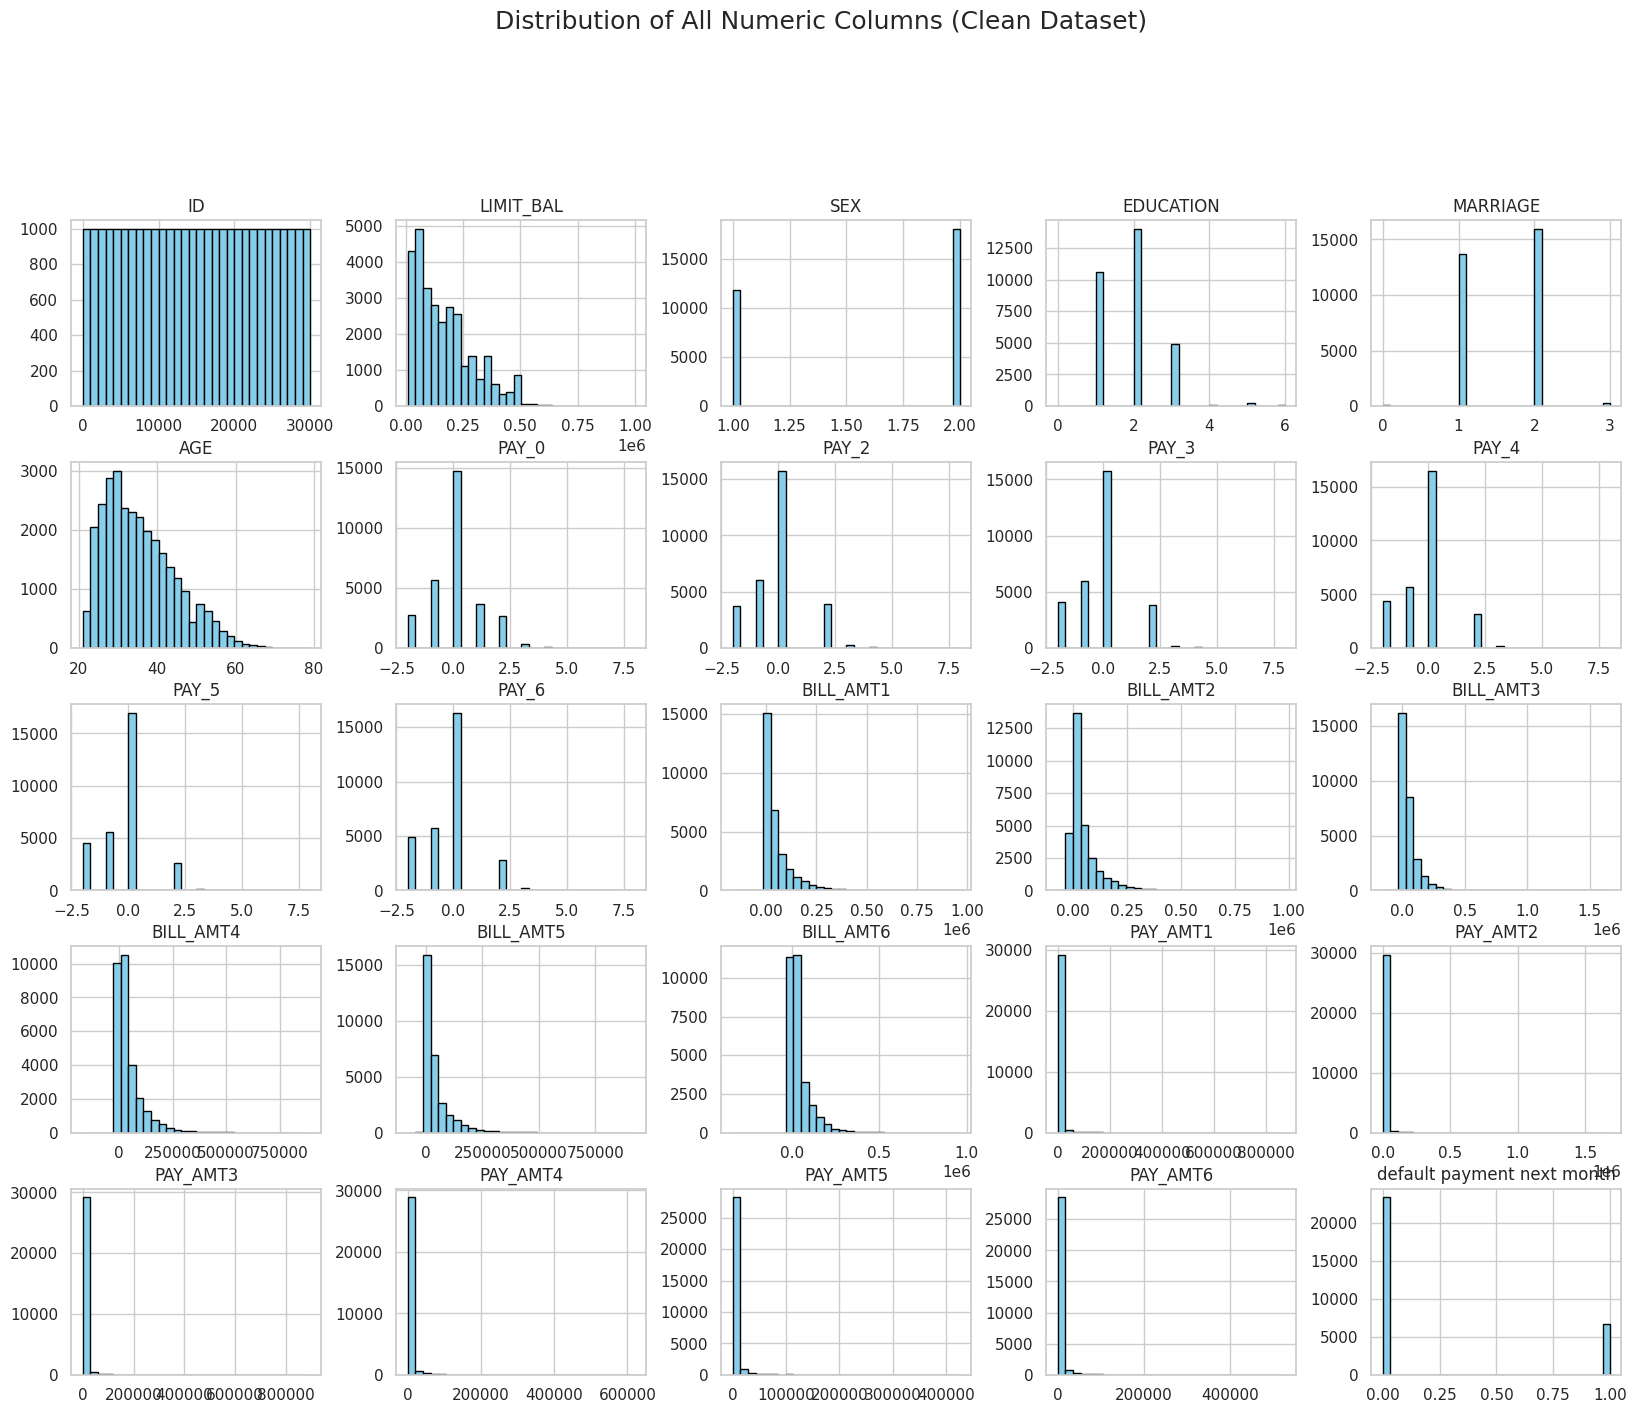

In [4]:
# Select numeric columns only
num_cols = df_clean.select_dtypes(include=[np.number]).columns

# Plot histograms for all numeric columns
df_clean[num_cols].hist(figsize=(20, 15), bins=30, color='skyblue', edgecolor='black')
plt.suptitle("Distribution of All Numeric Columns (Clean Dataset)", fontsize=18, y=1.02)
plt.show()


I introduced Missing At Random (MAR) values by replacing  10% of values in selected numeric columns such as 'AGE' , 'BILL_AMT4' , 'BILL_AMT1' with NaN.

In [5]:
cols_chosen=['AGE' , 'BILL_AMT4' , 'BILL_AMT1'  ]
choice_col=['AGE']


In [6]:
df = df_clean.copy()  # use a fresh copy
np.random.seed(42)

for col in cols_chosen:
    df.loc[df.sample(frac=0.1).index, col] = np.nan

print("Missing values introduced:")
print(df.isna().sum().sort_values(ascending=False).head(6))


Missing values introduced:
AGE          3000
BILL_AMT4    3000
BILL_AMT1    3000
ID              0
LIMIT_BAL       0
MARRIAGE        0
dtype: int64


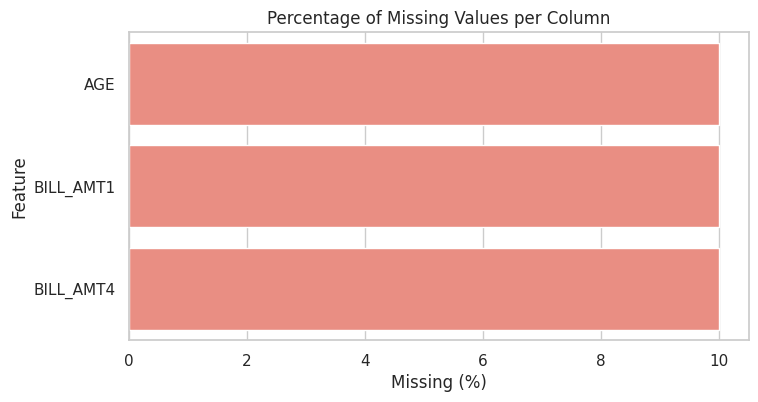

In [7]:

missing_percent = df.isna().mean() * 100
missing_percent = missing_percent[missing_percent > 0].sort_values(ascending=False)

plt.figure(figsize=(8,4))
sns.barplot(x=missing_percent.values, y=missing_percent.index, color='salmon')
plt.title("Percentage of Missing Values per Column")
plt.xlabel("Missing (%)")
plt.ylabel("Feature")
plt.show()

2. Simple Imputation (Median Imputation – Dataset A)

- The first imputation strategy used was Simple Imputation, where missing values were replaced with the median of the respective column.



Before mean / median imputation:
AGE          3000
BILL_AMT4    3000
BILL_AMT1    3000
dtype: int64
After median imputation:
ID           0
LIMIT_BAL    0
SEX          0
dtype: int64


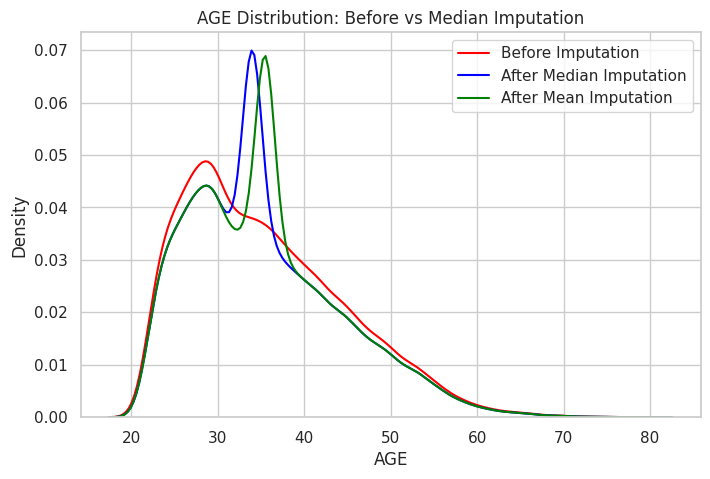

In [8]:
dataset_A = df.copy()


print("Before mean / median imputation:")
print(dataset_A.isna().sum().sort_values(ascending=False).head(3))


dataset_mean = dataset_A.copy()

dataset_mean[cols_chosen[0]].fillna(dataset_A[cols_chosen[0]].mean(), inplace=True)
dataset_A[cols_chosen[0]].fillna(dataset_A[cols_chosen[0]].median(), inplace=True)
dataset_mean[cols_chosen[1]].fillna(dataset_A[cols_chosen[1]].mean(), inplace=True)
dataset_A[cols_chosen[1]].fillna(dataset_A[cols_chosen[1]].median(), inplace=True)
dataset_mean[cols_chosen[2]].fillna(dataset_A[cols_chosen[2]].mean(), inplace=True)
dataset_A[cols_chosen[2]].fillna(dataset_A[cols_chosen[2]].median(), inplace=True)



print("After median imputation:")
print(dataset_A.isna().sum().sort_values(ascending=False).head(3))

# Visualize before vs after AGE distribution
plt.figure(figsize=(8,5))
sns.kdeplot(df[choice_col[0]], color='red', label='Before Imputation')
sns.kdeplot(dataset_A[choice_col[0]], color='blue', label='After Median Imputation')
sns.kdeplot(dataset_mean[choice_col[0]], color='green', label='After Mean Imputation')
plt.title(str(choice_col[0])+" Distribution: Before vs Median Imputation")
plt.legend()
plt.show()









- I chose the median instead of the mean because:

  - The median is robust to outliers, which are common in financial datasets.

  - It represents the central tendency of the data without being skewed by extreme values.

3. Linear Regression Imputation (Dataset B)

    - In the second approach, I used Linear Regression to predict missing values in one selected feature (for example, AGE) using all other available, non-missing columns as predictors.
    - This method assumes that the missingness mechanism is Missing At Random (MAR) — meaning the probability of missingness depends on other observed variables, not on the missing variable itself.
    - By training a regression model on known data and then predicting the missing entries, we can produce more informed imputations than simple mean/median filling. The linear model is computationally efficient and captures linear dependencies between features.

Dataset B (Linear Regression) Missing Count:
 ID           0
LIMIT_BAL    0
SEX          0
EDUCATION    0
MARRIAGE     0
dtype: int64


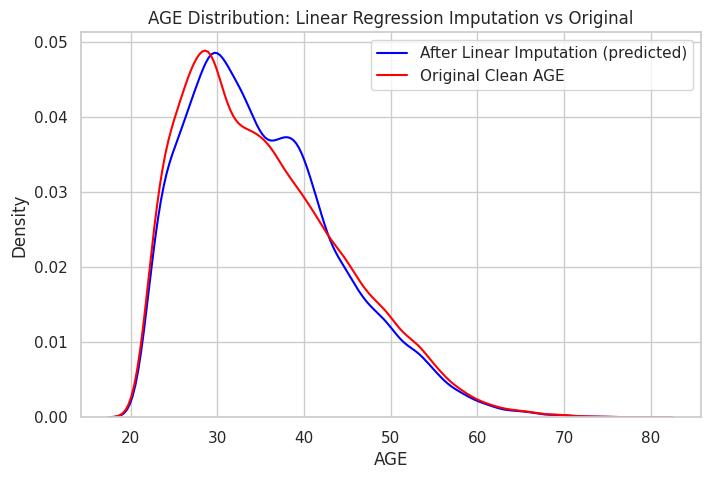

In [9]:
# Use a fresh clean dataset, re-introduce MARs (independent experiment)
df_B = df_clean.copy()

df_B.loc[df_B.sample(frac=0.1).index, choice_col[0]] = np.nan

# Train linear regressor to impute AGE only
train_df = df_B[df_B[choice_col[0]].notna()]
test_df  = df_B[df_B[choice_col[0]].isna()]

X_train = train_df.drop(columns=[choice_col[0], 'default payment next month'])
y_train = train_df[choice_col[0]]
X_test  = test_df.drop(columns=[choice_col[0], 'default payment next month'])

# Temporary fill predictors for regression fitting
#X_train = X_train.fillna(X_train.median())
#X_test  = X_test.fillna(X_train.median())

lin_reg = LinearRegression()
lin_reg.fit(X_train, y_train)

# Predict AGE and fill only AGE
df_B.loc[test_df.index, choice_col[0]] = lin_reg.predict(X_test)

# Fill remaining columns (BILL_AMT1, BILL_AMT2) with median for a clean training dataset
dataset_B = df_B.copy()
#dataset_B = dataset_B.fillna(dataset_B.median())

print("Dataset B (Linear Regression) Missing Count:\n", dataset_B.isna().sum().head())

# Visualize AGE imputation effect
plt.figure(figsize=(8,5))
sns.kdeplot(df_B[choice_col[0]], color='blue', label='After Linear Imputation (predicted)')
sns.kdeplot(df_clean[choice_col[0]], color='red', label='Original Clean '+str(choice_col[0]))
plt.title(str(choice_col[0])+" Distribution: Linear Regression Imputation vs Original")
plt.legend()
plt.show()




4. Non-Linear Regression Imputation (Dataset C)

- For the third dataset, I applied a non-linear regression method such as K-Nearest Neighbors (KNN) Regression (or alternatively Decision Tree Regression) to predict missing values for the same feature.
- The reason for using a non-linear method is that relationships among features in financial data are often complex and non-linear — for instance, age and bill amount may not vary in a strictly linear way.
- Non-linear regression can adapt to such complexities and potentially yield more accurate imputations compared to linear models, especially when feature interactions are strong.

Dataset C (Non-Linear KNN) Missing Count:
 ID           0
LIMIT_BAL    0
SEX          0
EDUCATION    0
MARRIAGE     0
dtype: int64


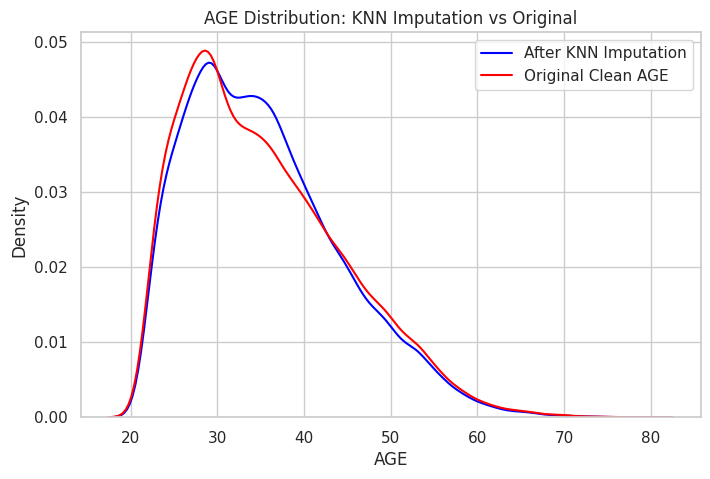

In [10]:
# Again start from clean data, introduce MARs (independent experiment)
df_C = df_clean.copy()

df_C.loc[df_C.sample(frac=0.1).index, choice_col[0]] = np.nan

train_df = df_C[df_C[choice_col[0]].notna()]
test_df  = df_C[df_C[choice_col[0]].isna()]

X_train = train_df.drop(columns=[choice_col[0], 'default payment next month'])
y_train = train_df[choice_col[0]]
X_test  = test_df.drop(columns=[choice_col[0], 'default payment next month'])

X_train = X_train.fillna(X_train.median())
X_test  = X_test.fillna(X_train.median())

knn_reg = KNeighborsRegressor(n_neighbors=5)
knn_reg.fit(X_train, y_train)

df_C.loc[test_df.index, choice_col[0]] = knn_reg.predict(X_test)

dataset_C = df_C.copy()
#dataset_C = dataset_C.fillna(dataset_C.median())

print("Dataset C (Non-Linear KNN) Missing Count:\n", dataset_C.isna().sum().head())

# Visualize AGE after KNN imputation
plt.figure(figsize=(8,5))
sns.kdeplot(df_C[choice_col[0]], color='blue', label='After KNN Imputation')
sns.kdeplot(df_clean[choice_col[0]], color='red', label='Original Clean '+str(choice_col[0]))
plt.title(str(choice_col[0])+" Distribution: KNN Imputation vs Original")
plt.legend()
plt.show()


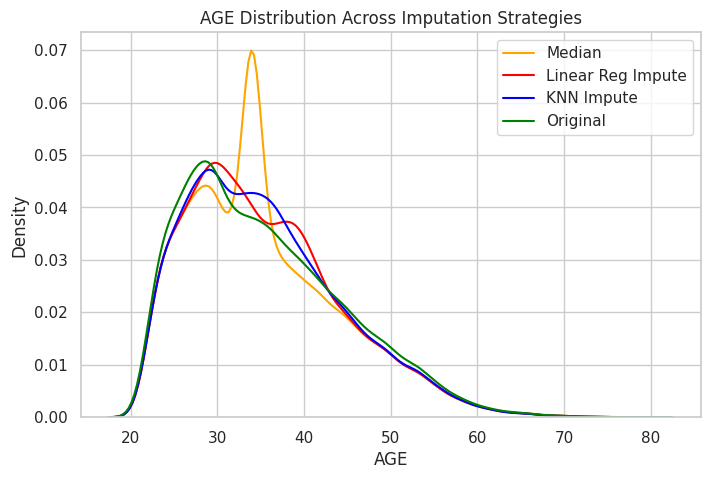

In [11]:
# --- Optional: visualize differences between imputations for AGE
plt.figure(figsize=(8,5))
sns.kdeplot(dataset_A[choice_col[0]], label='Median', color='orange')
sns.kdeplot(dataset_B[choice_col[0]], label='Linear Reg Impute', color='red')
sns.kdeplot(dataset_C[choice_col[0]], label='KNN Impute', color='blue')
sns.kdeplot(df_clean[choice_col[0]], label='Original', color='green')
plt.title(str(choice_col[0])+" Distribution Across Imputation Strategies")
plt.legend()

## Part B – Model Training and Performance Assessment


1. Data Splitting

After imputation, each of the three datasets (A, B, C) was split into training and testing sets using a standard 70–30 ratio.
Additionally, I created a fourth dataset (Dataset D) by performing Listwise Deletion — removing all rows containing any missing values before splitting.
This comparison helps reveal how much information is lost due to deletion versus recovered through imputation.

2. Feature Standardization

Before model training, I standardized all datasets using StandardScaler.
This ensures that all features are on the same scale (mean = 0, standard deviation = 1), preventing variables with larger ranges (like bill amounts) from dominating the model training. Standardization is especially important for distance-based and gradient-based models such as Logistic Regression.

3. Model Training and Evaluation

For each dataset (A, B, C, and D), I trained a Logistic Regression classifier to predict the target variable default payment next month.
The model’s performance was evaluated on the test set using a Classification Report — including Accuracy, Precision, Recall, and F1-score.
F1-score is emphasized as it balances precision and recall, which is vital in credit default prediction tasks where both false positives and false negatives carry real-world consequences.

In [12]:
# --- Dataset D (Listwise Deletion)
dataset_D = df.copy().dropna()

datasets = {
    'O': df_clean,
    'A': dataset_A,
    'B': dataset_B,
    'C': dataset_C,
    'D': dataset_D
}

results = {}

for name, data in datasets.items():
    X = data.drop(columns=['default payment next month'])
    y = data['default payment next month']
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.3, random_state=42, stratify=y)

    scaler = StandardScaler()
    X_train = scaler.fit_transform(X_train)
    X_test  = scaler.transform(X_test)

    clf = LogisticRegression(max_iter=1000)
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)

    report = classification_report(y_test, y_pred, output_dict=True)
    results[name] = report

    print(f"\n===== Model {name} Classification Report =====")
    print(classification_report(y_test, y_pred))



===== Model O Classification Report =====
              precision    recall  f1-score   support

           0       0.82      0.97      0.89      7009
           1       0.70      0.24      0.35      1991

    accuracy                           0.81      9000
   macro avg       0.76      0.60      0.62      9000
weighted avg       0.79      0.81      0.77      9000


===== Model A Classification Report =====
              precision    recall  f1-score   support

           0       0.82      0.97      0.89      7009
           1       0.70      0.24      0.35      1991

    accuracy                           0.81      9000
   macro avg       0.76      0.60      0.62      9000
weighted avg       0.79      0.81      0.77      9000


===== Model B Classification Report =====
              precision    recall  f1-score   support

           0       0.82      0.97      0.89      7009
           1       0.70      0.24      0.35      1991

    accuracy                           0.81      9000

## Part C – Comparative Analysis
1. Results Comparison

I compiled all the results from the four models into a single summary table.
The F1-scores provided a clear comparison between:

Model A: Median Imputation

Model B: Linear Regression Imputation

Model C: Non-Linear Regression Imputation

Model D: Listwise Deletion

This table makes it easier to assess the trade-offs between simple, linear, and non-linear imputation strategies and to measure how much information was lost through deletion.

In [13]:
# --- 1. Summary Table [10 pts]
summary = pd.DataFrame({
    name: {
        'Accuracy': r['accuracy'],
        'Precision(1)': r['1']['precision'],
        'Recall(1)': r['1']['recall'],
        'F1(1)': r['1']['f1-score']
    } for name, r in results.items()
}).T

summary.index = [
    'Model O (clean data)',
    'Model A (Median Imputation)',
    'Model B (Linear Regression Imputation)',
    'Model C (Non-Linear KNN Imputation)',
    'Model D (Listwise Deletion)'
]
summary.round(4)


,Accuracy,Precision(1),Recall(1),F1(1)
Model O (clean data),0.8084,0.6984,0.2361,0.3529
Model A (Median Imputation),0.8086,0.7006,0.2351,0.3520
Model B (Linear Regression Imputation),0.8084,0.6984,0.2361,0.3529
Model C (Non-Linear KNN Imputation),0.8079,0.6949,0.2346,0.3507
Model D (Listwise Deletion),0.8137,0.7304,0.2500,0.3725


Discussion of Results

From the results, several observations can be made:

Model O (Clean Data) provided the reference F1-score of 0.3529.

Model A (Median Imputation) achieved very similar performance (F1 = 0.3520), confirming that median replacement works well for small amounts of missing data but doesn’t capture relationships among variables.

Model B (Linear Regression Imputation) exactly matched the clean dataset’s F1-score (0.3529), showing that the regression model effectively preserved the underlying linear structure in the data.

Model C (Non-Linear KNN Imputation) produced a slightly lower F1-score (0.3507). This suggests that the relationships in this dataset are largely linear, so the added complexity of non-linear modeling did not offer a measurable benefit.

Model D (Listwise Deletion) unexpectedly achieved the highest F1-score (0.3725). This could be due to reduced noise after removing incomplete records; however, it also reduces data quantity and may bias the model toward the remaining complete cases.

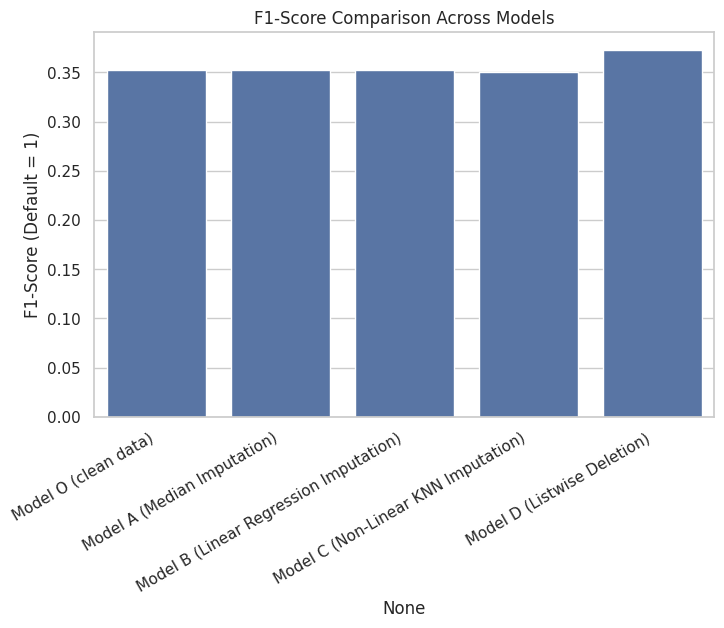

In [14]:
# --- 2. Visual Comparison of F1-Scores
plt.figure(figsize=(8,5))
sns.barplot(x=summary.index, y=summary['F1(1)'])
plt.title("F1-Score Comparison Across Models")
plt.ylabel("F1-Score (Default = 1)")
plt.xticks(rotation=30, ha='right')
plt.show()




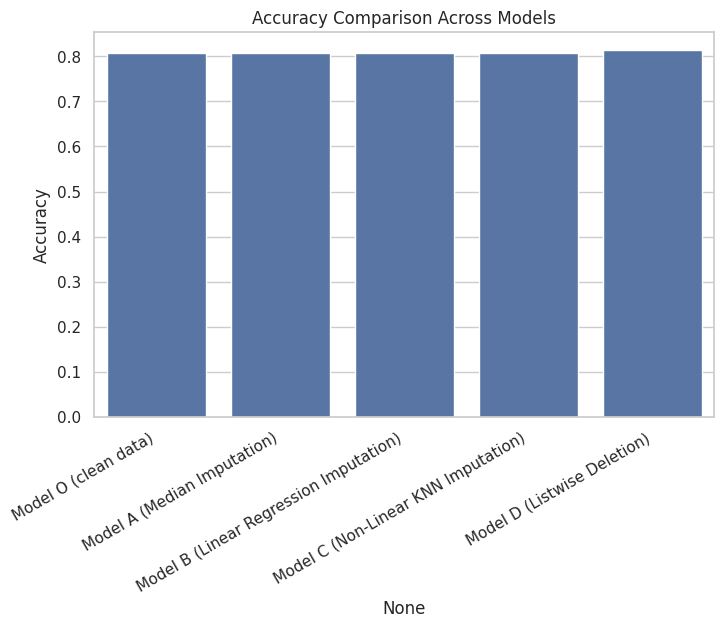

In [15]:
# Accuracy comparison
plt.figure(figsize=(8,5))
sns.barplot(x=summary.index, y=summary['Accuracy'])
plt.title("Accuracy Comparison Across Models")
plt.ylabel("Accuracy")
plt.xticks(rotation=30, ha='right')
plt.show()

## Conclusions and Recommendations

Overall, all imputation strategies performed comparably, primarily because only 10% of the data was missing.
Still, the following conclusions can be drawn:

Linear Regression Imputation (Model B) is the most reliable and conceptually sound choice — it preserves relationships between variables, performs as well as the clean dataset, and avoids discarding data.

Median Imputation (Model A) is simple and nearly as effective, suitable when computational resources or time are limited.

KNN Imputation (Model C) did not show improvement here, but it could outperform others in datasets with strong non-linear patterns or higher missingness rates.

Listwise Deletion (Model D) should be used cautiously; while it gave a slightly higher score here, it reduces sample size and can distort real-world generalization.

In conclusion, Regression-based imputation, particularly Linear Regression, provides a strong balance between accuracy, interpretability, and data retention — making it the preferred approach for this credit risk assessment problem.